# Minimal implementation of the *clusterITE* library

### Generate Data

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

In [2]:
# Sample a 2x2 orthonormal matrix
orth_mat = ortho_group.rvs(dim=2)

# Create a 2x2 positive semi-definite matrix with eigenvalues 2 and 3
sigma_mat = orth_mat @ np.diag([2, 3]) @ orth_mat.T

# Sample 1000 points from a 2D Gaussian
X = np.random.multivariate_normal(mean=[0, 0], cov=sigma_mat, size=1000)

In [3]:
# Create parameters for the probability of belonging to each of the 3 clusters
cl1_param = np.array([-9, -8])
cl2_param = np.array([9, 8])
cl3_param = np.array([-4, 2])

cl_param = np.array([cl1_param, cl2_param, cl3_param])

In [4]:
# Create these probabilities for each point
def softmax(X, cl_param, k):
    return np.exp(X @ cl_param[k]) / np.sum([np.exp(X @ cl_param[i]) for i in range(cl_param.shape[0])], axis=0)

def all_softmax(X, cl_param):
    return np.array([softmax(X, cl_param, k) for k in range(cl_param.shape[0])]).T

cluster_prob = all_softmax(X, cl_param)
cluster_prob

array([[9.37582718e-17, 1.00000000e+00, 2.30694131e-11],
       [1.81323077e-10, 9.48383253e-05, 9.99905161e-01],
       [8.86121228e-01, 1.37992222e-14, 1.13878772e-01],
       ...,
       [1.00000000e+00, 2.87941905e-29, 9.33563522e-16],
       [2.13320441e-10, 9.99999623e-01, 3.76642503e-07],
       [1.72864600e-06, 1.01902571e-03, 9.98979246e-01]])

NB: we picked parameters so that the real probabilities above are close to 0 or 1. This is merely for simplicity of the illustration, and could straightforwardly be complexified.

In [5]:
# For the real clusters, sample one hot encoded random vectors from a multinomial distribution
cluster_real_oh = np.array([np.random.multinomial(n=1, pvals=cluster_prob[i]) for i in range(cluster_prob.shape[0])])
cluster_real_oh

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [6]:
# Convert one hot encoding to categorical
cluster_real_cat = cluster_real_oh.argmax(axis=1)

# Number of points in each cluster
np.unique(cluster_real_cat, return_counts=True)

(array([0, 1, 2]), array([448, 454,  98]))

In [7]:
# Create parameters for each of the 3 experts
ex1_param = np.array([-.1, .8])
ex2_param = np.array([-.3, .5])
ex3_param = np.array([-.6, .3])

# Store the parameters in a 3x2 matrix
ex_param = np.array([ex1_param, ex2_param, ex3_param])

In [8]:
# Create all predictions for the 3 experts for all points
# To mimic individualized treatment effects (ITEs), bound the predictions between -1 and +1 like so
ex_preds = 2 * np.array([1 / (1 + np.exp(-X @  ex_param[ex])) for ex in range(ex_param.shape[0])]) - 1 

ex_preds.shape, (np.min(ex_preds), np.max(ex_preds))

((3, 1000), (-0.9414324901520605, 0.9694595422041645))

In [9]:
# Pick as real ITE the prediction from the corresponding cluster
# by applying the one-hot encoding mask like so
y = np.sum(ex_preds.T * cluster_real_oh, axis=1)
y.shape, (np.min(y), np.max(y))

((1000,), (-0.9365054133155385, 0.9398641539018067))

In [10]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Minimal implementation

In [11]:
from clusterITE import *

2023-08-17 01:24:02.988512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### All parametric

1. Pick the optimal number of cluster via cross-validation

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/francois/mambaforge/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(560, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
100%|██████████| 20/20 [01:19<00:00,  3.97s/it]


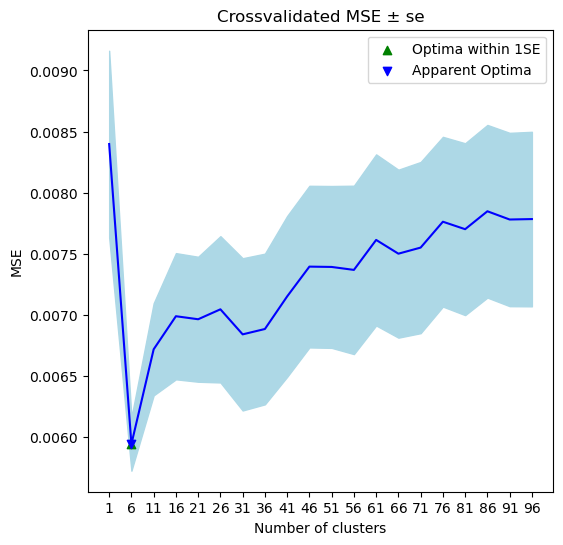

In [12]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(1,100,5))

# Plot the result
cv_model.plot()

2. Train a clusterITE model on all the data

In [13]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


3. Use your fitted model for cluster prediction and evaluation on unseen data

In [14]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gating_net.predict(X_test)

10/10 [==============================] - 0s 1ms/step


array([[0.34948838, 0.08424281, 0.11901551, 0.27199066, 0.06612603,
        0.10913673],
       [0.03696319, 0.1057616 , 0.35878998, 0.03807388, 0.18487288,
        0.2755384 ],
       [0.04909047, 0.15571731, 0.26757154, 0.05601769, 0.23312059,
        0.23848242],
       ...,
       [0.14132562, 0.14741156, 0.21348435, 0.13822119, 0.16326338,
        0.19629389],
       [0.19701082, 0.14394882, 0.16991088, 0.18691422, 0.1391814 ,
        0.16303383],
       [0.27966893, 0.04477036, 0.27602258, 0.16930507, 0.04709688,
        0.18313617]], dtype=float32)

In [15]:
# Evaluate the MSE of the final model on unseen data
mean_squared_error(final_model.predict(X_test), y_test)

0.006730460100920054

#### Non-parametric

1. Specify a model architecture

In [16]:
# For the gating network, define any Keras/Tensorflow architecture of your choice
def custom_tf_model(n_clusters):
    model = Sequential()
    ## Write your favorite architecture here...
    ## ... but make sure to finish the network like so
    model.add(Dense(n_clusters, use_bias=True, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

# For the expert networks, define any sklearn architecture of your choice
# and store both expert and gating network in a dictonary
base_learners = {'experts': RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10),
                 'gating_net': custom_tf_model}

2. Pick the optimal number of cluster via cross-validation

100%|██████████| 13/13 [04:35<00:00, 21.23s/it]


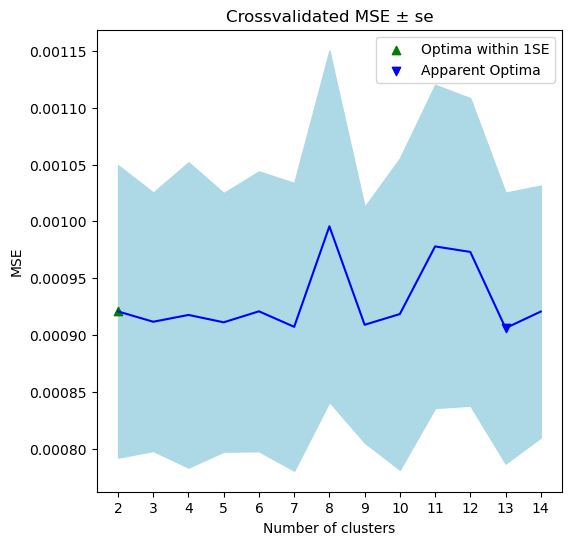

In [17]:
# Instanciate a ClusterIte model with 5 fold cross-validation
cv_model = ClusterIte_cv(nb_folds=5, **base_learners)

# Specify a range for the no. of clusters and fit this model to the data
cv_model.fit(X_train, y_train, cluster_range = range(2,15))

# Plot the result
cv_model.plot()

3. Train a clusterITE model on all the data

In [18]:
# Instanciate a ClusterIte model with the optimal K estimated from cross-validation
final_model = ClusterIte(K=cv_model.best_K, **base_learners)

# Instanciate this model on all the training data
final_model.fit(X_train, y_train)

Converged at iteration 2 with accuracy on H 100.00%


4. Use your fitted model for cluster prediction and evaluation on unseen data

In [20]:
# Use the gating network of your trained model to predict the probabilities 
# of belonging to clusters 1,...,K for unseen observations
final_model.gating_net.predict(X_test)

10/10 [==============================] - 0s 1ms/step


array([[0.0721863 , 0.20212162, 0.11781784, ..., 0.02649484, 0.12046463,
        0.04420298],
       [0.0098214 , 0.01008771, 0.00262112, ..., 0.03171198, 0.01021171,
        0.1283011 ],
       [0.02609576, 0.01777683, 0.010341  , ..., 0.07349395, 0.02205434,
        0.13159099],
       ...,
       [0.05410029, 0.06487507, 0.04180075, ..., 0.06152288, 0.05995343,
        0.09640509],
       [0.07260558, 0.09659916, 0.0766471 , ..., 0.05890128, 0.08437842,
        0.07401381],
       [0.0175053 , 0.13306539, 0.0133161 , ..., 0.00749149, 0.04824463,
        0.07392728]], dtype=float32)

In [ ]:
# Evaluate the MSE of the final model on unseen data
mean_squared_error(final_model.predict(X_test), y_test)